# TPT pipeline with ERA5

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
import feature_template
import feature_stratosphere
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import tpt_utils
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs

In [3]:
import matplotlib
matplotlib.rcParams["font.size"] = 18
%matplotlib inline

# Define some utility functions

In [4]:
def display_pole_field(field,lat,lon,u=None,v=None,vmin=None,vmax=None,fig=None,ax=None):
    # field, u, and v must have shape (lat, lon)
    data_crs = ccrs.PlateCarree() 
    ax_crs = ccrs.Orthographic(-10,90)
    if fig is None or ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection=ax_crs)
    im = ax.pcolormesh(lon,lat,field,shading='nearest',cmap='coolwarm',transform=data_crs,vmin=vmin,vmax=vmax)
    # If there's a vector field, overlay that 
    if u is not None and v is not None:
        lon_subset = np.arange(0,lon.size,3) #np.linspace(0,lon.size-1,24).astype(int)
        lat_subset = np.arange(2,lat.size-1,3) #np.linspace(1,lat.size-2,60).astype(int)
        ax.quiver(
            lon[lon_subset],lat[lat_subset],
            u[lat_subset,:][:,lon_subset],
            v[lat_subset,:][:,lon_subset],
            transform=data_crs,color='black',zorder=5,
        )
    ax.add_feature(cartopy.feature.COASTLINE, zorder=3, edgecolor='black')
    fig.colorbar(im,ax=ax)
    return fig,ax,data_crs

# Set up experiment

In [29]:
create_eofs_flag =                   0
featurize_flag =                     1
recombine_features_flag =            1

In [6]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-08-17"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-08-15"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-08-15",),
                "filename": "era5_features_tpt.nc",
            }),
        }),
        # TODO: add another directory for S2S hindcasts
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "tpt_quantities", "2022-08-15")
    })
})

In [7]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

In [8]:
file_list = [f for f in os.listdir(filedict["data"]["ra"]["traj"]["dir"]) if f.endswith(".nc")]
year_list = np.arange(1959,2019)

# Define any features that need defining, such as EOFs as linear coordinates

Assemble monthly anomalies

In [9]:
# Compute some EOFs of monthly mean data 
trajdir = filedict["data"]["ra"]["traj"]["dir"]
file_list = [join(trajdir, f) for f in os.listdir(trajdir)]
z_list = []
for i_f,f in enumerate(file_list):
    if i_f % 20 == 0:
        print(f"starting file {i_f} out of {len(file_list)}")
    zmean = xr.open_dataset(f)['z'].resample(time="1M").mean()
    z_list += [zmean] # Using the fact that each file is a whole month

starting file 0 out of 732
starting file 20 out of 732
starting file 40 out of 732
starting file 60 out of 732
starting file 80 out of 732
starting file 100 out of 732
starting file 120 out of 732
starting file 140 out of 732
starting file 160 out of 732
starting file 180 out of 732
starting file 200 out of 732
starting file 220 out of 732
starting file 240 out of 732
starting file 260 out of 732
starting file 280 out of 732
starting file 300 out of 732
starting file 320 out of 732
starting file 340 out of 732
starting file 360 out of 732
starting file 380 out of 732
starting file 400 out of 732
starting file 420 out of 732
starting file 440 out of 732
starting file 460 out of 732
starting file 480 out of 732
starting file 500 out of 732
starting file 520 out of 732
starting file 540 out of 732
starting file 560 out of 732
starting file 580 out of 732
starting file 600 out of 732
starting file 620 out of 732
starting file 640 out of 732
starting file 660 out of 732
starting file 680 ou

In [10]:
zm = xr.concat(z_list, dim="time").sortby("time")
zm_climatology = zm.groupby("time.month").mean(dim="time")
zma = zm.groupby("time.month") - zm_climatology # Anomaly

Assemble a data matrix. Restrict to EOFs north of 20 degrees N

In [11]:
zm_20N_w = zma.where(
    (zma.latitude >= 20) *
    zma.month.isin([10, 11, 12, 1, 2, 3]),
    drop=True
) 
zm_20N_w *= np.sqrt(np.maximum(0, np.cos(zm_20N_w.latitude*np.pi/180)))
X = zm_20N_w.transpose("level","time","latitude","longitude").to_numpy().reshape((
    zm_20N_w.level.size, zm_20N_w.time.size, zm_20N_w.latitude.size*zm_20N_w.longitude.size, 
))

In [12]:
num_modes = 10
eofs = xr.DataArray(
    coords = {
        "level": zm_20N_w.level, 
        "latitude": zm_20N_w.latitude, 
        "longitude": zm_20N_w.longitude, 
        "mode": 1 + np.arange(num_modes)},
    dims = ["level", "latitude", "longitude", "mode"],
)
variance_fraction = xr.DataArray(
    coords = {"level": zm_20N_w.level, "mode": 1 + np.arange(num_modes),},
    dims = ["level","mode"],
)

In [13]:
for i_lev in range(eofs.level.size):
    U,S,Vh = np.linalg.svd(X[i_lev].T, full_matrices=False)
    eofs[dict(level=i_lev)] = U[:,:num_modes].reshape((eofs.latitude.size, eofs.longitude.size, eofs.mode.size))
    variance_fraction[dict(level=i_lev)] = S[:num_modes]**2 / np.sum(S**2)

Save the EOFs as well as monthly climatology

In [14]:
statsdir = filedict["data"]["ra"]["stats"]["dir"]
ds_eofs = xr.Dataset(
    data_vars = {"eofs": eofs, "variance_fraction": variance_fraction,},
)
eofdir = filedict["data"]["ra"]["stats"]["dir"]
ds_eofs.to_netcdf(join(statsdir, filedict["data"]["ra"]["stats"]["eof_filename"]))
ds_monclim = xr.Dataset(
    data_vars = {"z": zm_climatology}
)
ds_monclim.to_netcdf(join(statsdir, filedict["data"]["ra"]["stats"]["monthly_climatology_filename"]))

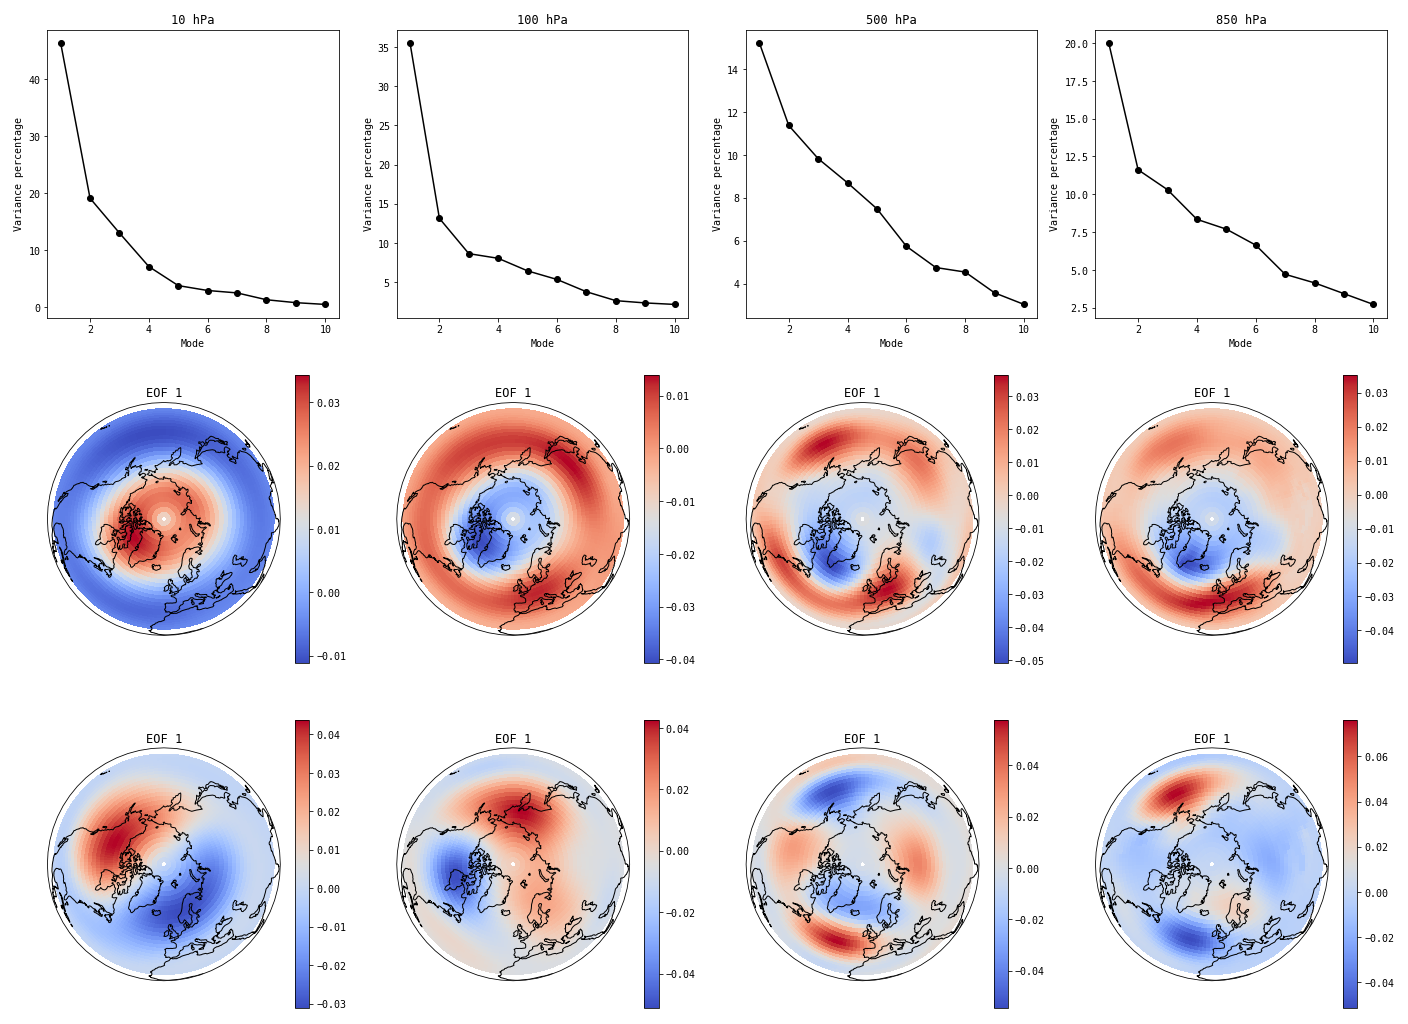

In [15]:
fig = plt.figure(figsize=(24,18))
for i_lev in range(4):
    # Plot singular value spectrum
    ax = fig.add_subplot(3,4,i_lev+1)
    vf = variance_fraction.isel(level=i_lev)
    ax.plot(variance_fraction.mode, 100*variance_fraction.isel(level=i_lev), marker='o', color='black')
    ax.set_xlabel("Mode")
    ax.set_ylabel("Variance percentage")
    ax.set_title(f"{variance_fraction.level.data[i_lev]} hPa")
    # Plot EOF 1
    ax = fig.add_subplot(3,4,4+i_lev+1,projection=ccrs.Orthographic(-10,90))
    display_pole_field(eofs.sel(mode=1).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    # Plot EOF 2
    ax = fig.add_subplot(3,4,8+i_lev+1,projection=ccrs.Orthographic(-10,90))
    display_pole_field(eofs.sel(mode=2).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    

Save the EOF data to file where we can use it for features.

## Read database and compute features. 

In [16]:
reload(feature_stratosphere)

<module 'feature_stratosphere' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/feature_stratosphere.py'>

In [17]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

Load EOF information to use for computing features

In [18]:
statsdir = filedict["data"]["ra"]["stats"]["dir"]
ds_eofs = xr.open_dataset(join(statsdir, filedict["data"]["ra"]["stats"]["eof_filename"]))
ds_monclim = xr.open_dataset(join(statsdir, filedict["data"]["ra"]["stats"]["monthly_climatology_filename"]))

In [19]:
if featurize_flag:
    feat_all = dict()
    for src in ["ra"]:
        ds_feature_list = []
        file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if f.endswith(".nc")]
        for i_filename,filename in enumerate(file_list):
            ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
            if i_filename % 12 == 0:
                print(f"Starting file number {i_filename} out of {len(file_list)}")
            ds_feature_list += [
                xr.Dataset(
                    data_vars = dict({
                        # WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
                        # For example, if the identity observable and energy observable both have a coordinate called "feature", 
                        # then xarray will assume it's the same and smush them together, filling in NaNs. This restricts what 
                        # we can use as feature names. 
                        "time_feature": feat_strat.time_observable(ds).resample(time="1D").last(),
                        "ubar_feature": feat_strat.ubar_observable(ds).resample(time="1D").mean(),
                        "pc_feature": feat_strat.pc_observable(ds, ds_eofs, ds_monclim).resample(time="1D").mean(),
                    })
                )
            ]
            ds.close()
        # Combine all the Datasets into a single one, concatenating either by time (if reanalysis) or ensemble (if S2S)
        concat_dim = "time" if src == "ra" else "ensemble"
        feat_all[src] = xr.concat(ds_feature_list,dim=concat_dim) # ensemble is a new dimension
        feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

Starting file number 0 out of 732
Starting file number 12 out of 732
Starting file number 24 out of 732
Starting file number 36 out of 732
Starting file number 48 out of 732
Starting file number 60 out of 732
Starting file number 72 out of 732
Starting file number 84 out of 732
Starting file number 96 out of 732
Starting file number 108 out of 732
Starting file number 120 out of 732
Starting file number 132 out of 732
Starting file number 144 out of 732
Starting file number 156 out of 732
Starting file number 168 out of 732
Starting file number 180 out of 732
Starting file number 192 out of 732
Starting file number 204 out of 732
Starting file number 216 out of 732
Starting file number 228 out of 732
Starting file number 240 out of 732
Starting file number 252 out of 732
Starting file number 264 out of 732
Starting file number 276 out of 732
Starting file number 288 out of 732
Starting file number 300 out of 732
Starting file number 312 out of 732
Starting file number 324 out of 732
St

In [20]:
feat_all = dict()
for src in ["ra"]:
    feat_all[src] = xr.open_dataset(
        join(
            filedict["data"][src]["feat_all"]["dir"], 
            filedict["data"][src]["feat_all"]["filename"]
        )
    ).sortby("time")

Plot some climatological envelopes

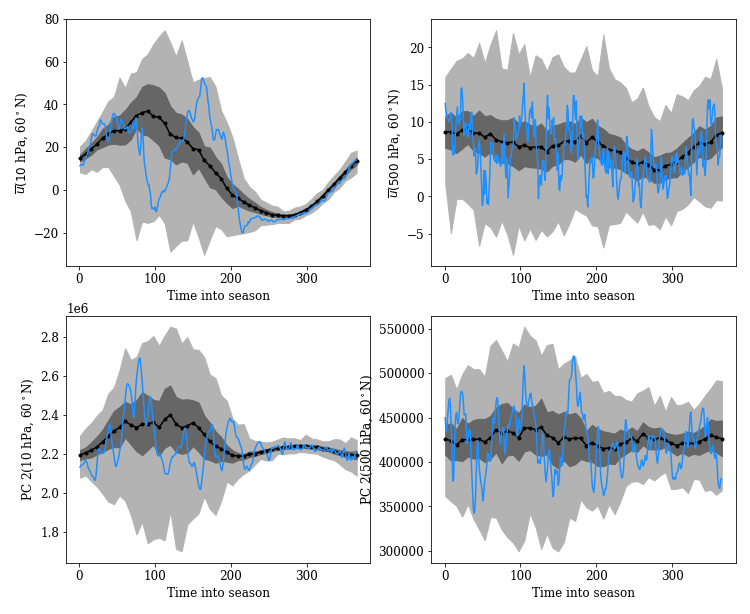

In [180]:
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
year2plot = 2018
cond = 1*(feat_all["ra"]["time_feature"].sel(time_type="year_szn_start") == year2plot)
ra_one_season = feat_all["ra"].where(cond,drop=True)

tpt_utils.plot_field_1d(
    feat_all["ra"]["ubar_feature"].sel(ubar_60="ubar_10_60").to_numpy(), 
    np.ones(feat_all["ra"]["time"].size), 
    feat_all["ra"]["time_feature"].sel(time_type="t_szn").to_numpy(),
    feat_name="Time into season", field_name="$\overline{u}(10$ hPa, 60$^\circ$N)",
    fig=fig, ax=axes.flat[0], nbins=50
)
axes.flat[0].plot(
    ra_one_season["time_feature"].sel(time_type="t_szn").to_numpy(),
    ra_one_season["ubar_feature"].sel(ubar_60="ubar_10_60").to_numpy(),
    color='dodgerblue'
)
tpt_utils.plot_field_1d(
    feat_all["ra"]["ubar_feature"].sel(ubar_60="ubar_500_60").to_numpy(), 
    np.ones(feat_all["ra"]["time"].size), 
    feat_all["ra"]["time_feature"].sel(time_type="t_szn").to_numpy(),
    feat_name="Time into season", field_name="$\overline{u}(500$ hPa, 60$^\circ$N)",
    fig=fig, ax=axes.flat[1], nbins=50
)
axes.flat[1].plot(
    ra_one_season["time_feature"].sel(time_type="t_szn").to_numpy(),
    ra_one_season["ubar_feature"].sel(ubar_60="ubar_500_60").to_numpy(),
    color='dodgerblue'
)
tpt_utils.plot_field_1d(
    feat_all["ra"]["pc_feature"].sel(pc="pc_10_2").to_numpy(), 
    np.ones(feat_all["ra"]["time"].size), 
    feat_all["ra"]["time_feature"].sel(time_type="t_szn").to_numpy(),
    feat_name="Time into season", field_name="PC 2(10 hPa, 60$^\circ$N)",
    fig=fig, ax=axes.flat[2], nbins=50
)
axes.flat[2].plot(
    ra_one_season["time_feature"].sel(time_type="t_szn").to_numpy(),
    ra_one_season["pc_feature"].sel(pc="pc_10_2").to_numpy(),
    color='dodgerblue'
)
tpt_utils.plot_field_1d(
    feat_all["ra"]["pc_feature"].sel(pc="pc_500_2").to_numpy(), 
    np.ones(feat_all["ra"]["time"].size), 
    feat_all["ra"]["time_feature"].sel(time_type="t_szn").to_numpy(),
    feat_name="Time into season", field_name="PC 2(500 hPa, 60$^\circ$N)",
    fig=fig, ax=axes.flat[3], nbins=50
)
axes.flat[3].plot(
    ra_one_season["time_feature"].sel(time_type="t_szn").to_numpy(),
    ra_one_season["pc_feature"].sel(pc="pc_500_2").to_numpy(),
    color='dodgerblue'
)

Plot some two-dimensional densities, at multiple time slices throughout the season.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='u_10_60', ylabel='pc_10_2'>)

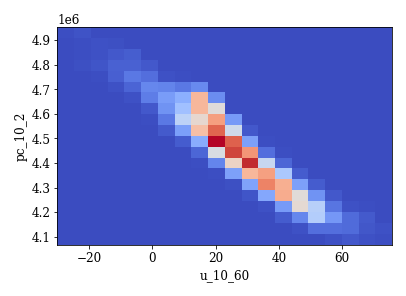

In [28]:
fig,ax = plt.subplots()
cond = 1*(
    (feat_all["ra"]["time_feature"].sel(time_type="t_szn") > 0) * 
    (feat_all["ra"]["time_feature"].sel(time_type="t_szn") < 150)
)
tpt_utils.plot_field_2d(
    np.ones(feat_all["ra"]["time"].where(cond,drop=True).size), 
    np.ones(feat_all["ra"]["time"].where(cond,drop=True).size),
    np.array([
        feat_all["ra"]["ubar_feature"].where(cond,drop=True).sel(ubar_60="ubar_10_60").to_numpy(),
        feat_all["ra"]["pc_feature"].where(cond,drop=True).sel(pc="pc_10_1").to_numpy(),        
    ]).T,
    feat_names = ["u_10_60", "pc_10_2"],
    fig=fig, ax=ax, shp=[20,20],
    stat_name="weightsum"
)

# Assemble features for TPT.

In [68]:
t_cal = feat_all[src]["time_feature"].sel(time_type="t_cal").astype(int)

In [39]:
feat_all[src]["time_feature"]["time_type"]

<xarray.DataArray 'time_type' (time_type: 6)>
array(['t_dt64', 't_abs', 't_cal', 't_szn', 'year_cal', 'year_szn_start'],
      dtype=object)
Coordinates:
  * time_type  (time_type) object 't_dt64' 't_abs' ... 'year_szn_start'

In [47]:
feat_all[src]["pc_feature"].coords

Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2019-12-31
  * pc       (pc) object 'pc_10_1' 'pc_10_2' 'pc_10_3' ... 'pc_850_3' 'pc_850_4'

In [155]:
if recombine_features_flag:
    feat_tpt = dict()
    # List the features to put into feat_tpt
    # First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
    # over some time horizon. 
    num_time_delays = 20 # Units are days
    levels = [10, 100, 500, 850]
    pcs = [1, 2, 3, 4]
    feat_tpt_list = (
        ["t_abs","t_szn","year_szn_start","t_cal",] + 
        [f"ubar_{level}_60_delay{delay}" for level in levels for delay in range(num_time_delays+1)] + 
        [f"pc_{level}_{i_pc}" for level in levels for i_pc in pcs]
    )
    for src in ["ra"]:
        t_abs = feat_all[src]["time_feature"].sel(time_type="t_abs").to_numpy()
        t_sim = t_abs - t_abs[0]
        feat_tpt[src] = xr.Dataset(
            data_vars = {
                "X": xr.DataArray(               
                    coords = {
                        #TODO: for S2S, modify ensemble and member coordinates
                        "ensemble": np.arange(1),
                        "member": np.arange(1),
                        "t_sim":  t_sim,
                        "feature": feat_tpt_list,
                    },
                    dims = ["ensemble","member","t_sim","feature"],
                )
            }
        )
        print(feat_tpt[src]["X"].coords)
        # Time observables
        t_names = ["t_abs","t_szn","year_szn_start","t_cal"]
        feat_tpt[src]["X"].loc[dict(feature=t_names)] = (
            feat_all[src]["time_feature"].sel(time_type=t_names)
        )
        # PC observables
        pc_names = [f"pc_{level}_{i_pc}" for level in levels for i_pc in pcs]
        feat_tpt[src]["X"].loc[dict(feature=pc_names)] = (
            feat_all[src]["pc_feature"].sel(pc=pc_names)
        )
        # Time-delayed zonal wind observables
        for i_delay in range(num_time_delays+1):
            tidx_in = np.arange(num_time_delays-i_delay,len(t_abs)-i_delay)
            tidx_out = np.arange(num_time_delays,len(t_abs))
            ubar_names_in = [f"ubar_{level}_60" for level in levels]
            ubar_names_out = [f"ubar_{level}_60_delay{i_delay}" for level in levels]
            feat_tpt[src]["X"].loc[dict(feature=ubar_names_out,t_sim=t_sim[tidx_out])] = (
                feat_all[src]["ubar_feature"].sel(ubar_60=ubar_names_in)
                .isel(time=tidx_in).to_numpy()
            )

        # Save 
        feat_tpt[src].to_netcdf(join(filedict["data"][src]["feat_tpt"]["dir"], filedict["data"][src]["feat_tpt"]["filename"]))

Coordinates:
  * ensemble  (ensemble) int64 0
  * member    (member) int64 0
  * t_sim     (t_sim) float64 0.0 1.0 2.0 3.0 ... 2.228e+04 2.228e+04 2.228e+04
  * feature   (feature) <U19 't_abs' 't_szn' ... 'pc_850_3' 'pc_850_4'


# Compute the source and destination: A and B 

In [162]:
reload(feature_stratosphere)

<module 'feature_stratosphere' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/feature_stratosphere.py'>

In [199]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
feat_strat.set_ab_boundaries(40, 150, 0.0)

In [200]:
compute_empirical_committor_flag = 1

In [201]:
if compute_empirical_committor_flag:
    ab_tag = dict()
    cej = dict() # Hitting times (Cotton-eye Joe)
    comm_emp = dict() # Empirical committor: to B in forward time, from A in backward time
    for src in ["ra"]:
        ab_tag[src] = feat_strat.ab_test(feat_tpt[src]["X"])
        mode = "timechunks" if src == "ra" else "timesteps" # This determines the computation pattern for iterating through the dataset
        cej[src] = feat_strat.cotton_eye_joe(feat_tpt[src]["X"],ab_tag[src],mode=mode)
        comm_emp[src] = 1*(cej[src].sel(state="B") < cej[src].sel(state="A"))
        comm_emp[src].loc[dict(sense="since")] = 1 - comm_emp[src].sel(sense="since")
        # Save each item
        ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
        cej[src].to_netcdf(join(filedict["results"]["dir"], f"cej_{src}.nc"))    
        comm_emp[src].to_netcdf(join(filedict["results"]["dir"], f"comm_emp_{src}.nc"))

t_sim.shape = (22280,)


Plot some pictures of the committor 

In [202]:
feat_tpt["ra"]["X"].shape

(1, 1, 22280, 104)

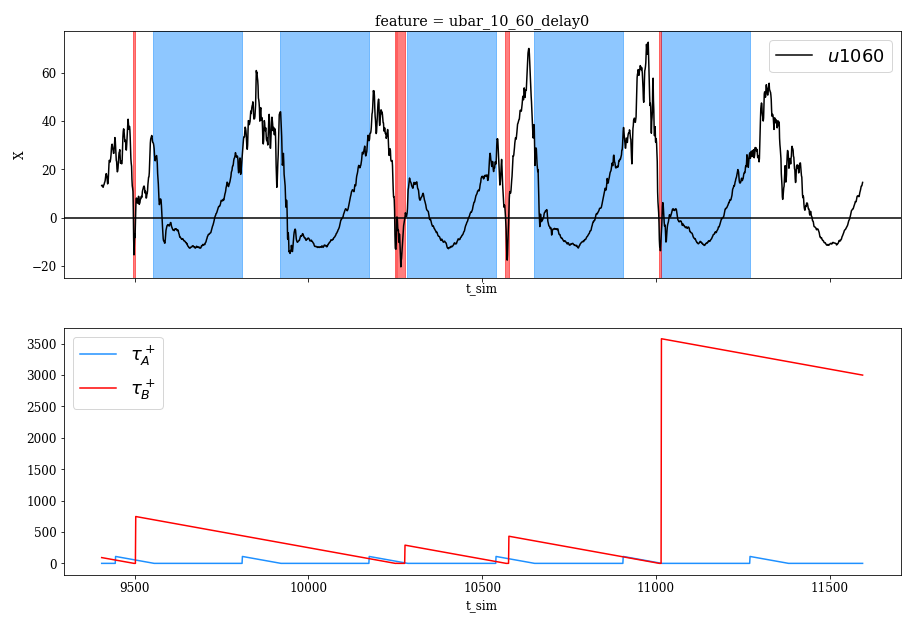

In [206]:
fig,axes = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
years2plot = np.arange(1984,1990)
tidx, = np.where(np.in1d(feat_tpt["ra"]["X"].sel(feature="year_szn_start").to_numpy(), years2plot))
isel = dict(ensemble=0,member=0, t_sim=tidx)
h_ubar, = xr.plot.plot(
    feat_tpt["ra"]["X"].isel(isel,drop=True).sel(feature="ubar_10_60_delay0"),
    color="black",ax=axes[0],label="$u1060$",x="t_sim"
)
handles = []
for set_code in ["A","B"]:
    color = "dodgerblue" if set_code == "A" else "red"
    starts, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == 1)
    ends, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == -1)
    if starts[0] > ends[0]: 
        ends = ends[1:]
    if starts[-1] > ends[-1]:
        starts = starts[:-1]
    for i in range(len(starts)):
        axes[0].axvspan(
            feat_tpt["ra"]["t_sim"][tidx[starts[i]]], feat_tpt["ra"]["t_sim"][tidx[ends[i]]], 
            color=color, alpha=0.5, zorder=-1
        )
    h_hittime, = xr.plot.plot(
        cej["ra"].isel(isel,drop=True).sel(state=set_code, sense="until", drop=True),
        ax=axes[1], label=r"$\tau_%s^+$"%(set_code), color=color)
    handles += [h_hittime]

axes[0].axhline(y=feat_strat.tpt_bndy["ubar_10_60_thresh"], color='black')
axes[0].legend(handles=[h_ubar], prop={"size": 18})
axes[1].legend(handles=handles, prop={"size": 18})


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='pc_850_3', ylabel='Lead time to B'>)

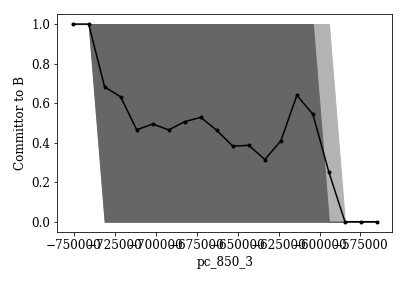

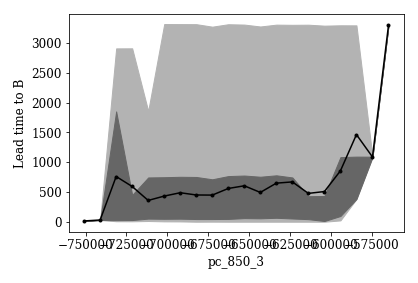

In [225]:
feat = "pc_850_3" # The independent variable
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0]+50) 
)
tpt_utils.plot_field_1d(
    comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1],
    feat_name=feat, field_name="Committor to B"
)
tpt_utils.plot_field_1d(
    cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)


(<Figure size 1080x360 with 3 Axes>,
 <AxesSubplot:title={'center':'$-\\eta_B^+$'}, xlabel='t_szn', ylabel='pc_10_1'>)

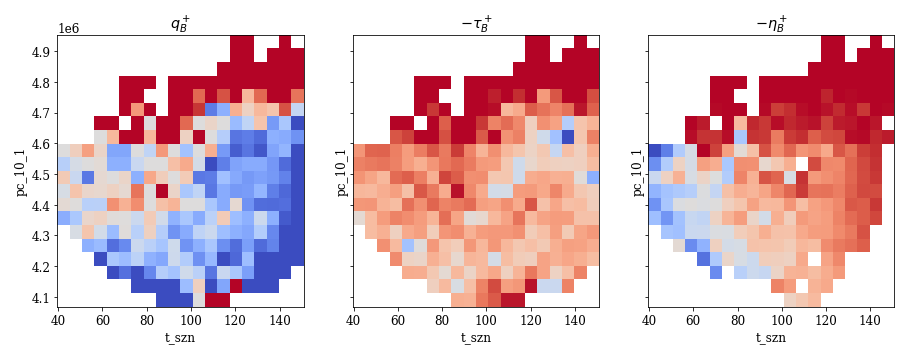

In [246]:
# Choose the two features
feat0,feat1 = "t_szn","pc_10_1"
# Select the first ensemble and member (trivial for reanalysis: there's only one realization)
sel = dict(ensemble=0,member=0) 
# Take a slice of the season, between two times
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][1]) 
)
# Call the committor qp (q-plus) and the hitting time to B Tb
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
# First plot: committor
tpt_utils.plot_field_2d(
    qp, # function values
    np.ones(feat_tpt["ra"]["t_sim"].size), # weights
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True), # Feature space
    feat_names = [feat0,feat1],  # axis labels
    shp=[20,20], # shape of the 2D grid controls how pixellated the image is
    fig=fig, ax=axes[0], field_name=r"$q_B^+$" #other display parameters
)
# Second plot: hitting time (negative, so it increases towards B)
tpt_utils.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[1], field_name=r"$-\tau_B^+$"
)
# Third plot: hitting time conditioned on hitting B first
tpt_utils.plot_field_2d(
    -Tb*qp,
    qp,
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[2], field_name=r"$-\eta_B^+$"
)
